In [ ]:
https://www.lucypark.kr/docs/2015-pyconkr/#56

#### 1) 데이터 및 라이브러리 로드

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [6]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
df = pd.read_table('./data/ratings.txt')
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


#### 2) 데이터 전처리

In [7]:
print(df.isnull().values.any()) # 결측값 유무 확인
print(df.isnull().values.any()) # Null 값이 존재하는지 확인

True
True


In [10]:
print(len(df))
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(len(df))

200000
199992


In [11]:
# 정규 표현식을 통한 한글 외 문자 제거
df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df.head()

C:\Users\heo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\heo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


#### 3) 토큰화 및 임베딩 생성

In [13]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

from tqdm import tqdm
tokenized_data = []
for sentence in tqdm(df['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [07:52<00:00, 423.33it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


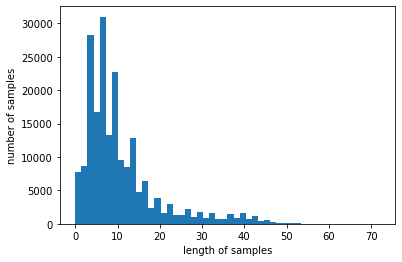

In [14]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 500, sg=1)

# window : 훈련시 앞 뒤로 고려하는 단어의 개수 
# sg=1 : skip-gram / 0 : CBOW
# worker : 스레드 개수
# min count : 최소 빈도수, 해당 빈도수보다 작게 등장한 단어의 경우 모델 학습에서 배제

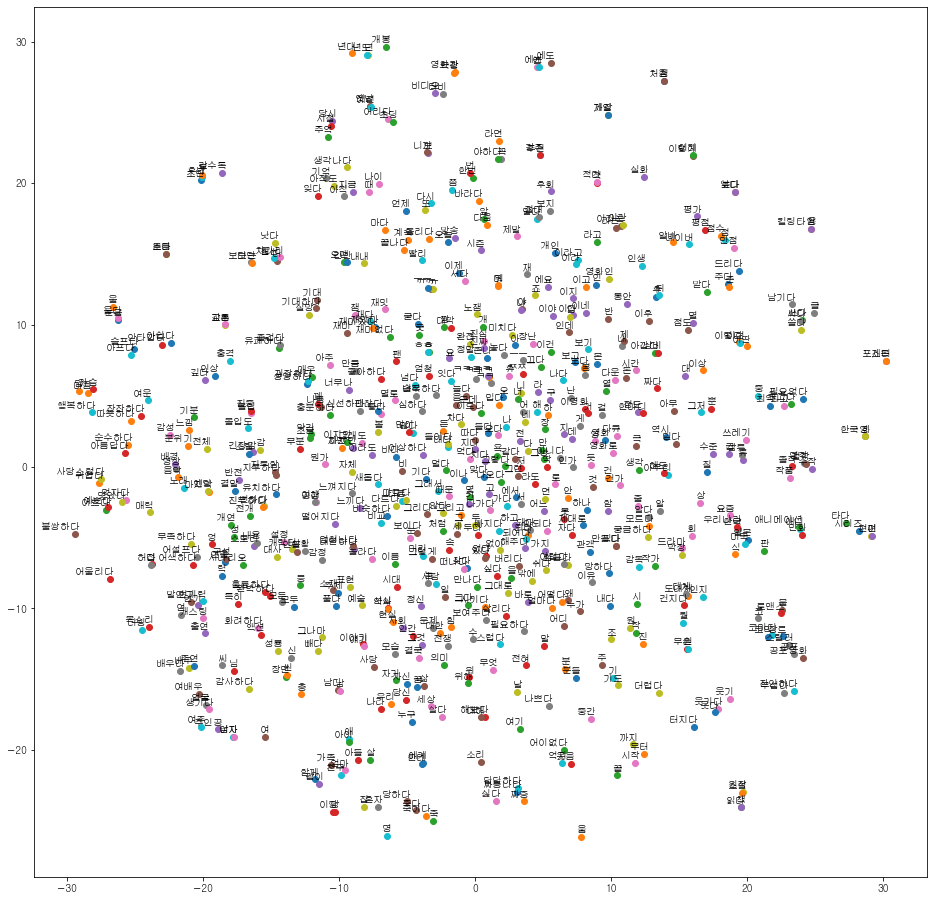

In [21]:
# 모델링 이후 주성분분석을 통한 데이터 분포 확인
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

labels = [i for i in model.wv.key_to_index]
tokens = model.wv[labels]
tsne_model = TSNE(init='pca',learning_rate='auto')
new_values = tsne_model.fit_transform(tokens)

# 한글폰트 지정
from matplotlib import font_manager, rc
font_fname = 'c:/windows/fonts/gulim.ttc'     # A font of your choice
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family='gulim')

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(new_values.shape[0]):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

#### 4) 군집화
엄밀히 말하면 텍스트의 라벨링은 아니지만 군집화를 통해 단어 군집을 구성하여 유사도 비교 및 분류를 시행해보자. 이때, 네이버 리뷰 데이터의 긍부정 라벨이 아닌 군집으로 하겠다.
- K-Means를 통한 클러스터화
- CTM을 통한 토픽화

In [22]:
document_vectors = model.wv.vectors

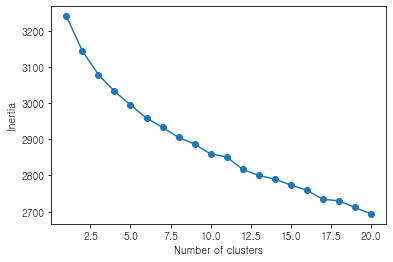

In [24]:
# 적정 클러스터 개수 찾기
from sklearn.cluster import KMeans

inertia = []
for i in range(1,21): 
    kmeans_plus = KMeans(n_clusters=i, init='k-means++')
    kmeans_plus.fit(document_vectors)
    inertia.append(kmeans_plus.inertia_)
    
plt.plot(range(1,21), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [25]:
# Perform k-means clustering
num_clusters = 10  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(document_vectors)
kmeans_labels = kmeans.labels_

kmeans_labels

array([3, 5, 4, 9, 9, 9, 9, 2, 6, 6, 6, 9, 9, 4, 6, 9, 9, 9, 9, 9, 5, 9,
       5, 6, 1, 4, 3, 6, 4, 9, 3, 9, 9, 9, 2, 7, 6, 7, 0, 7, 5, 6, 6, 7,
       9, 9, 5, 6, 1, 8, 6, 9, 9, 6, 6, 2, 6, 2, 5, 3, 6, 7, 6, 9, 9, 2,
       6, 4, 6, 5, 9, 7, 9, 7, 7, 4, 3, 7, 9, 5, 3, 1, 6, 9, 9, 6, 6, 6,
       6, 9, 6, 6, 1, 2, 1, 7, 9, 7, 7, 9, 3, 6, 6, 4, 5, 6, 2, 6, 6, 6,
       2, 2, 5, 9, 6, 9, 3, 3, 5, 6, 8, 1, 5, 9, 6, 0, 7, 6, 9, 6, 2, 5,
       9, 6, 4, 5, 1, 5, 5, 1, 9, 5, 2, 0, 4, 4, 5, 5, 1, 5, 4, 9, 6, 7,
       9, 1, 5, 5, 9, 3, 2, 0, 6, 1, 8, 6, 6, 4, 2, 5, 2, 7, 5, 8, 3, 2,
       5, 1, 9, 6, 9, 4, 5, 0, 2, 5, 1, 1, 0, 4, 3, 5, 2, 0, 3, 4, 1, 3,
       3, 6, 0, 9, 5, 4, 9, 1, 1, 7, 6, 9, 2, 0, 8, 4, 7, 3, 7, 9, 9, 9,
       0, 4, 6, 5, 9, 6, 5, 4, 8, 7, 4, 9, 9, 2, 9, 9, 1, 7, 2, 3, 8, 4,
       4, 6, 6, 1, 2, 9, 6, 2, 6, 8, 1, 7, 6, 8, 9, 4, 6, 0, 3, 6, 5, 2,
       7, 8, 5, 0, 4, 8, 3, 5, 2, 2, 9, 6, 8, 2, 8, 9, 6, 4, 8, 1, 7, 4,
       6, 6, 0, 7, 5, 1, 0, 9, 8, 8, 2, 1, 7, 6, 5,

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality of document vectors
tsne = TSNE(n_components=2, random_state=35)
document_vectors_2d = tsne.fit_transform(document_vectors)

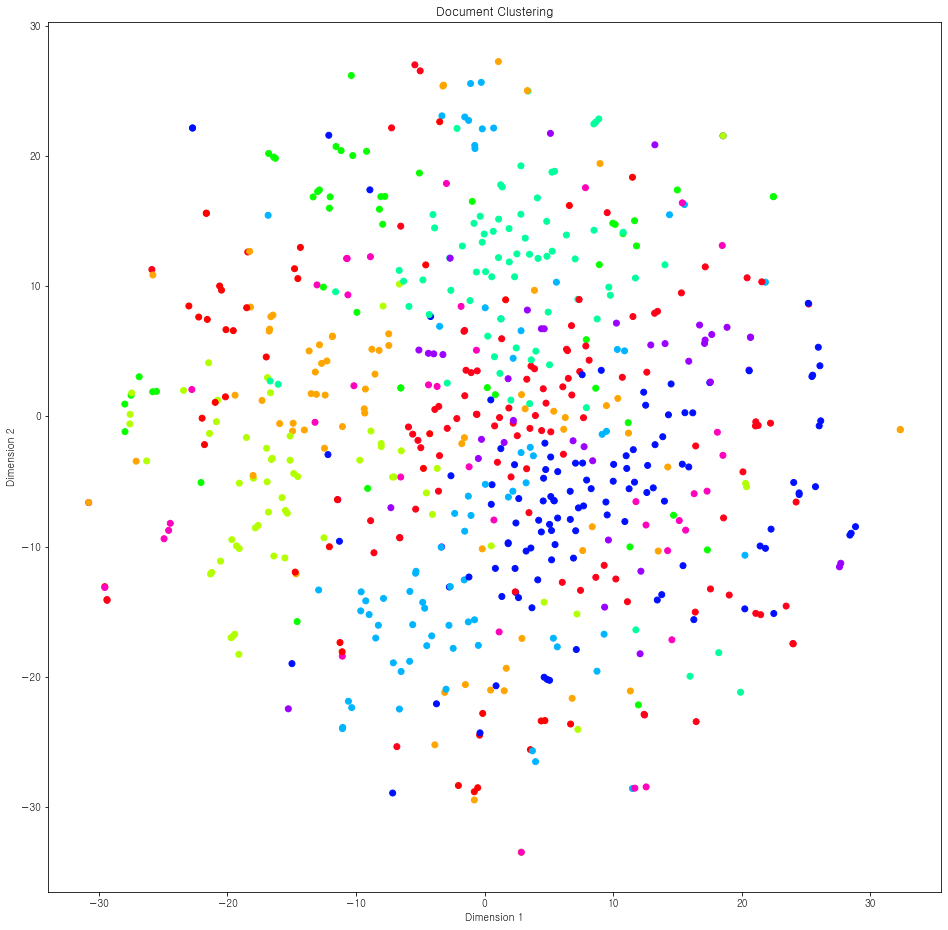

In [35]:
# Plot the clusters
plt.figure(figsize=(16, 16)) 
plt.scatter(document_vectors_2d[:, 0], document_vectors_2d[:, 1], c=kmeans_labels, cmap='hsv')
plt.title("Document Clustering")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

특징추출하는 번거로움 대신 딥러닝 활용하여 추출/분류 한번에 

#### EDA

In [42]:
labels = []
tokens = []

for word in model.wv.key_to_index:
    tokens.append(model.wv[word])
    labels.append(word)
        
labels

['영화',
 '보다',
 '을',
 '없다',
 '이다',
 '있다',
 '좋다',
 '너무',
 '다',
 '정말',
 '재밌다',
 '되다',
 '만',
 '적',
 '진짜',
 '같다',
 '로',
 '아니다',
 '않다',
 '점',
 '에서',
 '만들다',
 '나오다',
 '평점',
 '연기',
 '것',
 '최고',
 '내',
 '그',
 '나',
 '인',
 '안',
 '생각',
 '못',
 '스토리',
 '왜',
 '드라마',
 '게',
 '감동',
 '사람',
 '보고',
 '이렇다',
 '아깝다',
 '말',
 '고',
 '더',
 '때',
 'ㅋㅋ',
 '배우',
 '감독',
 '아',
 '재미있다',
 '그냥',
 '거',
 '요',
 '재미',
 '시간',
 '내용',
 '까지',
 '중',
 '주다',
 '뭐',
 '재미없다',
 '자다',
 '하고',
 '지루하다',
 '쓰레기',
 '수',
 '네',
 '가다',
 '들다',
 '모르다',
 '그렇다',
 '싶다',
 '지',
 '사랑',
 '작품',
 '알다',
 '볼',
 '다시',
 '하나',
 '마지막',
 '이건',
 '저',
 '정도',
 'ㅠㅠ',
 '오다',
 'ㅋ',
 '완전',
 '많다',
 '처음',
 'ㅋㅋㅋ',
 '장면',
 '액션',
 '주인공',
 '이렇게',
 '안되다',
 '걸',
 '차다',
 '나다',
 '최악',
 '하',
 '개',
 '이야기',
 '지금',
 '돈',
 '별로',
 'ㅡㅡ',
 '임',
 '넘다',
 '연출',
 '느낌',
 '끝',
 '좋아하다',
 '라',
 '인데',
 '듯',
 '명작',
 '년',
 '기',
 '역시',
 '그리고',
 '받다',
 '많이',
 '별',
 '남다',
 '이해',
 '난',
 '면',
 '이런',
 '괜찮다',
 '분',
 '라고',
 '이영화',
 '느끼다',
 '버리다',
 '때문',
 '서',
 '또',
 '여자',
 '이나',
 '부터',
 '성',
 '아름답다',
 '해주다',

In [44]:
count = []
for i in labels :
    count.append(model.wv.get_vecattr(i, "count"))
count

[67908,
 54956,
 30959,
 20944,
 17735,
 16599,
 16180,
 14891,
 13589,
 12995,
 12104,
 11919,
 11690,
 11680,
 11270,
 11171,
 10488,
 10430,
 10284,
 10184,
 9313,
 8747,
 8576,
 8537,
 8489,
 8430,
 8049,
 7939,
 7606,
 7496,
 7368,
 7354,
 7140,
 7041,
 7031,
 6833,
 6710,
 6708,
 6516,
 6478,
 6188,
 6110,
 6022,
 6000,
 5982,
 5864,
 5798,
 5702,
 5692,
 5529,
 5528,
 5493,
 5434,
 5426,
 5334,
 5238,
 5171,
 5163,
 5119,
 5066,
 5005,
 4981,
 4890,
 4875,
 4732,
 4722,
 4660,
 4553,
 4541,
 4363,
 4288,
 4242,
 4137,
 4074,
 4021,
 4004,
 3987,
 3911,
 3822,
 3771,
 3766,
 3654,
 3481,
 3436,
 3433,
 3381,
 3372,
 3361,
 3353,
 3294,
 3266,
 3261,
 3229,
 3178,
 3176,
 3116,
 3084,
 3072,
 3067,
 3049,
 3041,
 2977,
 2942,
 2920,
 2912,
 2892,
 2834,
 2804,
 2797,
 2797,
 2783,
 2770,
 2767,
 2737,
 2733,
 2720,
 2714,
 2694,
 2673,
 2657,
 2648,
 2631,
 2610,
 2581,
 2568,
 2546,
 2540,
 2520,
 2514,
 2446,
 2442,
 2432,
 2426,
 2426,
 2368,
 2366,
 2358,
 2350,
 2348,
 2339,


In [53]:
label_cnt = pd.DataFrame({'labels':labels, 'count':count})
new_df = label_cnt.sort_values('count', ascending=False)

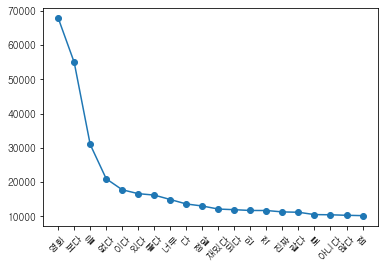

In [56]:
plt.plot(new_df['labels'][:20], new_df['count'][:20], marker='o')
plt.xticks(rotation=45)
plt.show()